**Read NIFTI Files and preprocess them**

In [54]:
import nibabel as nib
import os
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(
        self, root:str, img_size:int=256,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root

# Read the nifti file and resize the frames. After the frames are resized, the frames are stacked and normalised

    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'new.nii')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }

    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'{self.root}/BraTS2021_{patient_id}_{scan_type}_new.nii'
        return self.read_file(scan_filename)


**Point Cloud Generation**

In [55]:
import plotly.graph_objects as go
import numpy as np

### Generating scatter points for the point cloud ###
def generate_3d_scatter(
    x:np.array, y:np.array, z:np.array, colors:np.array,
    size:int=3, opacity:float=0.4, scale:str='emrld',
    hover:str='skip', name:str='MRI'
) -> go.Scatter3d:
    return go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers', hoverinfo=hover,
        marker = dict(
            size=size, opacity=opacity,
            color=colors, colorscale=scale
        ),
        name=name
    )


class ImageViewer3d():
    def __init__(
        self, reader:ImageReader,
        mri_downsample:int=10, mri_colorscale:str='emrld'
    ) -> None:
        self.reader = reader
        self.mri_downsample = mri_downsample
        self.mri_colorscale = mri_colorscale
        
# Downsampling the Data
    def load_clean_mri(self, image:np.array, orig_dim:int) -> dict:
        shape_offset = image.shape[1]/orig_dim
        z, x, y = (image > 0).nonzero()
        x, y, z = x[::self.mri_downsample], y[::self.mri_downsample], z[::self.mri_downsample]
        colors = image[z, x, y]
        return dict(x=x/shape_offset, y=y/shape_offset, z=z, colors=colors)
        
# Segmenting the tumor classes
    def load_tumor_segmentation(self, image:np.array, orig_dim:int) -> dict:
        color_1 = ['yellow', 'blue', 'orange']
        tumors = {}
        shape_offset = image.shape[1]/orig_dim
        sampling = {
            1: 1, 2: 1, 4: 1
        }
        for class_idx in sampling:
            z, x, y = (image == class_idx).nonzero()
            x, y, z = x[::sampling[class_idx]], y[::sampling[class_idx]], z[::sampling[class_idx]]
            tumors[class_idx] = dict(
                x=x/shape_offset, y=y/shape_offset, z=z,
                colors=color_1[class_idx%4]
            )
        return tumors

# Generating point clouds for all three tumor classes

    def collect_patient_data(self, scan:dict) -> tuple:
        tumors_dict = {}
        clean_mri = self.load_clean_mri(scan['scan'], scan['orig_shape'][0])
        tumors = self.load_tumor_segmentation(scan['segmentation'], scan['orig_shape'][0])
        for class_idx in tumors:
              tumors_dict[class_idx] = tumors[class_idx]['x'].shape[0]
        markers_created = clean_mri['x'].shape[0] + sum(tumors[class_idx]['x'].shape[0] for class_idx in tumors)
        return [
            generate_3d_scatter(
                **clean_mri, scale=self.mri_colorscale, opacity=0.4,
                hover='all', name='0: Brain Structure'
            ),
            generate_3d_scatter(
                **tumors[1], opacity=0.4,
                hover='all', name='1: NCR (Necrotic tumor core)'
            ),
            generate_3d_scatter(
                **tumors[2], opacity=0.4,
                hover='all', name='2: ED (Edema i.e. swelling around the tumor)'
            ),
            generate_3d_scatter(
                **tumors[4], opacity=0.4,
                hover='all', name='4: ET (Enhancing Tumor)'
            ),
        ], markers_created, tumors_dict

    def get_3d_scan(self, patient_idx:int, scan_type:str='flair') -> go.Figure:
        scan = self.reader.load_patient_scan(patient_idx, scan_type)
        data, num_markers, tumors_dict = self.collect_patient_data(scan)
        fig = go.Figure(data=data)
        fig.update_layout(
            font=dict(
                family="Courier New, monospace",
                size=14,
            ),
            margin=dict(
                l=0, r=0, b=0, t=30
            ),
            legend=dict(itemsizing='constant', x=0.75,
        y=1, )
        )
        return fig

In [56]:
reader = ImageReader('../data', img_size=128, normalize=True, single_class=False)
viewer = ImageViewer3d(reader, mri_downsample=20)

In [57]:
import plotly
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)


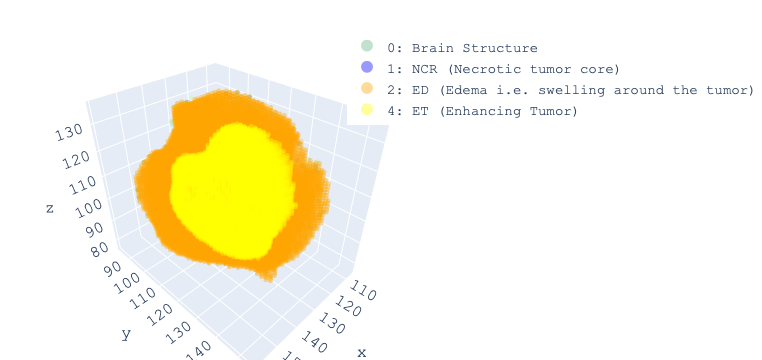

In [58]:
fig = viewer.get_3d_scan(3, 'seg')
plotly.offline.iplot(fig)
fig.show(renderer="colab")

**Volume Estimation**

In [59]:
import nibabel as nib

nii_file_path = '../data/BraTS2021_00003_seg_new.nii'
nii_image = nib.load(nii_file_path)

header = nii_image.header


voxel_dims = header.get_zooms()

# Calculate the volume of that voxel by multiplying the volume in all three dimensions
voxel_volume = voxel_dims[0] * voxel_dims[1] * voxel_dims[2]

# Calculate the volume for that particular tumor class
scan = reader.load_patient_scan(3, 'seg')
data, num_markers, tumors_dict = viewer.collect_patient_data(scan)
tumor_volume_1 = voxel_volume * tumors_dict[1]
tumor_volume_2 = voxel_volume * tumors_dict[2]
tumor_volume_4 = voxel_volume * tumors_dict[4]
print('1:', tumor_volume_1 ,"mm^3  2:" , tumor_volume_2 ,"mm^3  4:" , tumor_volume_4,"mm^3")

print("Surrounding Tissue Damage (in mm^3)", tumor_volume_2)


1: 4979.0 mm^3  2: 16441.0 mm^3  4: 6808.0 mm^3
Surrounding Tissue Damage (in mm^3) 16441.0


**Depth Estimation**

In [60]:
import nibabel as nib
import numpy as np
nii_scan = nib.load('../data/BRaTS2021_00003_t1_new.nii')
scan_data = nii_scan.get_fdata()
mask_scan = nib.load('../data/BraTS2021_00003_seg_new.nii')
mask_data = mask_scan.get_fdata()

# Identify the brain tissue points in the segmentation mask
brain_tissue_indices = np.where(mask_data == 0)

# Identify tumor points in the segmentation mask
tumor_indices = np.where((mask_data == 4) | (mask_data == 2) | (mask_data == 1) )

# Calculate the depth by getting the brain and tumor voxel distance in each dimension
topmost_brain_voxel_z = np.min(brain_tissue_indices[2])
topmost_tumor_voxel_z = np.min(tumor_indices[2])
bottomost_brain_voxel_z = np.max(brain_tissue_indices[2])

rightmost_brain_voxel_x = np.min(brain_tissue_indices[0])
rightmost_tumor_voxel_x = np.min(tumor_indices[0])
leftmost_brain_voxel_x = np.max(brain_tissue_indices[0])

backmost_brain_voxel_y = np.min(brain_tissue_indices[1])
backmost_tumor_voxel_y = np.min(tumor_indices[1])
frontmost_brain_voxel_y = np.max(brain_tissue_indices[1])

tumor_depth_from_topmost_brain_voxel_z = topmost_tumor_voxel_z - topmost_brain_voxel_z
tumor_depth_from_bottomost_brain_voxel_z = topmost_tumor_voxel_z - bottomost_brain_voxel_z

tumor_depth_from_rightmost_brain_voxel_x = rightmost_tumor_voxel_x - rightmost_brain_voxel_x
tumor_depth_from_leftmost_brain_voxel_x = rightmost_tumor_voxel_x - leftmost_brain_voxel_x

tumor_depth_from_backmost_brain_voxel_y = backmost_tumor_voxel_y - backmost_brain_voxel_y
tumor_depth_from_frontmost_brain_voxel_y = backmost_tumor_voxel_y - frontmost_brain_voxel_y


# Real world depth calculated using the voxel dimensions

voxel_dims = (1.0, 1.0, 1.0) 
real_world_depth_top_mm_z = tumor_depth_from_topmost_brain_voxel_z * voxel_dims[2]  
real_world_depth_bottom_mm_z = tumor_depth_from_bottomost_brain_voxel_z * voxel_dims[2] 

real_world_depth_right_mm_x = tumor_depth_from_rightmost_brain_voxel_x * voxel_dims[0]
real_world_depth_left_mm_x = tumor_depth_from_leftmost_brain_voxel_x * voxel_dims[0]

real_world_depth_front_mm_y = tumor_depth_from_backmost_brain_voxel_y  * voxel_dims[1]
real_world_depth_back_mm_y = tumor_depth_from_frontmost_brain_voxel_y * voxel_dims[1]

print("###### W.R.T Topmost Tumor Point #####")
print("Tumor depth from topmost brain voxel_z   (in voxel units):", tumor_depth_from_topmost_brain_voxel_z)
print("Tumor depth from topmost brain voxel_z   (in mm):", real_world_depth_top_mm_z )
print("Tumor depth from bottomost brain voxel_z (in voxel units):", tumor_depth_from_bottomost_brain_voxel_z)
print("Tumor depth from bottomost brain voxel_z (in mm):", real_world_depth_bottom_mm_z)
print("___________________________________________________________" + '\n')

print("###### W.R.T Rightmost Tumor Point #####")
print("Tumor depth from rightmost brain voxel_x (in voxel units):", tumor_depth_from_rightmost_brain_voxel_x)
print("Tumor depth from rightmost brain voxel_x (in mm):", real_world_depth_right_mm_x )
print("Tumor depth from leftmost brain voxel_x  (in voxel units):", tumor_depth_from_leftmost_brain_voxel_x)
print("Tumor depth from leftmost brain voxel_x  (in mm):", real_world_depth_left_mm_x )
print("___________________________________________________________" + '\n')

print("###### W.R.T Backmost Tumor Point #####")
print("Tumor depth from backmost brain voxel_y (in voxel units):", tumor_depth_from_backmost_brain_voxel_y )
print("Tumor depth from backmost brain voxel_y (in mm):", real_world_depth_front_mm_y )
print("Tumor depth from frontmost brain voxel_y  (in voxel units):", tumor_depth_from_frontmost_brain_voxel_y )
print("Tumor depth from frontmost brain voxel_y (in mm):", real_world_depth_back_mm_y)

###### W.R.T Topmost Tumor Point #####
Tumor depth from topmost brain voxel_z   (in voxel units): 77
Tumor depth from topmost brain voxel_z   (in mm): 77.0
Tumor depth from bottomost brain voxel_z (in voxel units): -77
Tumor depth from bottomost brain voxel_z (in mm): -77.0
___________________________________________________________

###### W.R.T Rightmost Tumor Point #####
Tumor depth from rightmost brain voxel_x (in voxel units): 108
Tumor depth from rightmost brain voxel_x (in mm): 108.0
Tumor depth from leftmost brain voxel_x  (in voxel units): -131
Tumor depth from leftmost brain voxel_x  (in mm): -131.0
___________________________________________________________

###### W.R.T Backmost Tumor Point #####
Tumor depth from backmost brain voxel_y (in voxel units): 83
Tumor depth from backmost brain voxel_y (in mm): 83.0
Tumor depth from frontmost brain voxel_y  (in voxel units): -156
Tumor depth from frontmost brain voxel_y (in mm): -156.0


**Linear Registration of the NIFTI segmentation mask to convert it into MNI152 space**

In [61]:
!flirt -in ../data/BraTS2021_00003_seg_new.nii -ref $FSLDIR/data/standard/MNI152_T1_1mm_brain.nii.gz -out ../data/registered_brain_03.nii.gz -omat ../data/transformation_matrix.mat -interp nearestneighbour -dof 6 -cost mutualinfo


**Tumor Distribution Across Brain Regions**

In [62]:
!atlasquery -a "Harvard-Oxford Subcortical Structural Atlas" -m ../data/registered_brain_03.nii.gz

Left Cerebral Cortex:0.0013
Brain-Stem:0.6528
Right Cerebral White Matter:5.5427
Right Cerebral Cortex:15.7124
Right Lateral Ventricle:0.0028
Right Hippocampus:0.0090


**Taking the calculated volume and adding it to the NIFTI file header**

In [63]:
import nibabel as nib

file_path = '../data/registered_brain_03.nii.gz'

nii = nib.load(file_path)

# The above calculated tumor volumes
tumor_volumes = {
    'Necrosis': 4979.0,
    'Peritumoral Edema': 16441.0,
    'Enhancing Tumor': 6808.0
}

volume_str = '; '.join(f"{key}: {value }" for key, value in tumor_volumes.items())

header = nii.header
header['descrip'] = volume_str + ('(mm^3)')



nib.save(nii, '../data/registered_brain_03_volume.nii.gz')



**Launching FSLeyes with configured format**

In [64]:
!fsleyes $FSLDIR/data/standard/MNI152_T1_1mm_brain.nii.gz ../data/registered_brain_03_volume.nii.gz -cm hot

  from . import (
see the appropriate new directories, set the environment variable
`JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
The use of platformdirs will be the default in `jupyter_core` v6
  from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
